# Hasting Direct Exercise

In this exercise we are given a dataset of car insurance quotes and we have the task of exploring, cleansing and analysing the data in order to create a model that predicts how much each customer should be charged.

Let us first import all the necessary modules.

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, plot_importance

## Data cleansing and analysis
Before any modelling we need to explore the data so that we can cleanse it. This will require as well some analysis of distribution and correlation of the features, to understand which features are more relevant and which values might be erroneous.

First we read the dataset and have a glance at it.

In [477]:
quotes = pd.read_csv("Grad_Scheme_Case_Study_Dataset.csv")
quotes

,Quote_ID,Quote_Date,Driver1_DOB,Driver1_Licence_Type,Driver1_Licence_Years,Driver2_Licence_Type,Driver2_Licence_Years,Driver1_Convictions,Driver1_Claims,Driver1_Marital_Status,Vehicle_Age,Vehicle_Value,Tax,Vehicle_Annual_Mileage,Credit_Score,Payment_Type,Days_to_Inception,Premium,Capped_Premium
0,190537,01/09/2020,16/06/1959,Full UK,34.0,NaN,NaN,No,0,Married,4,24178,3626.70,12849.0,240,Monthly,11,707.64,707.64
1,161332,06/01/2020,03/09/1977,Full UK,12.0,NaN,NaN,No,2,Married,14,1744,174.40,1250.0,200,Annual,4,1176.96,1176.96
2,161666,21/07/2020,24/03/1990,Full UK,9.0,NaN,20.0,No,0,Married,5,20199,3029.85,21847.0,644,Annual,0,594.84,594.84
3,171589,07/11/2020,11/03/1980,Full UK,17.0,Full UK,NaN,No,2,Married,6,12569,1885.35,12266.0,548,Annual,0,1282.56,1282.56
4,154037,16/08/2020,17/09/1977,Full UK,25.0,Full UK,NaN,No,0,Separated,8,11395,1709.25,11117.0,393,Annual,30,1471.02,1471.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,121858,11/05/2020,03/12/1990,Full UK,12.0,NaN,24.0,No,0,Other,14,1633,244.95,1074.0,397,Annual,30,451.50,451.50
49996,184868,02/07/2020,01/08/1992,Full UK,1.0,Full UK,25.0,No,0,Married,6,8050,1207.50,2987.0,158,Monthly,4,1375.59,1375.59
49997,182922,05/01/2020,18/07/1989,Automatic,13.0,NaN,24.0,No,0,Civil Partnership,8,11124,1112.40,3364.0,328,Annual,3,1207.05,1207.05
49998,183787,14/11/2020,17/11/1949,Full UK,0.0,Provisional UK,11.0,No,0,Single,3,10821,1623.15,9303.0,277,Monthly,0,1776.93,1776.93


We are going to drop any duplicates. We use the Quote ID to identify duplicates. We can also check that all the duplicated Quote ID's are entirely duplicated, in other words, there are no two different quotes with the same ID.

In [478]:
# The number of duplicated quote ID's is equal to the number of overall duplicates
quotes[quotes.duplicated(subset = "Quote_ID",keep="first")].shape[0] == quotes[quotes.duplicated(keep="first")].shape[0]

True

In [479]:
# We drop the duplicates and compute the new number of rows
quotes.drop_duplicates(keep="first",inplace=True, ignore_index=True)
quotes.shape[0]

49641

We can see that we have a similar amount of rows. From now we are going analyse each column to decide whether to keep it or drop it, see its range or unique values, and to find any missing or potentially wrong values. 

Let us start by the Quote ID. We ar enot really going to need this column for the model since it is just and identifier. However, before dropping it, we are going to check if there are any missing values, since these would not have been marked as duplicated.

In [480]:
#No missing values
any(quotes["Quote_ID"].isna())

False

In [481]:
# Drop Quote ID and show a few rows
quotes.drop(columns=["Quote_ID"], inplace=True)
quotes.head()

,Quote_Date,Driver1_DOB,Driver1_Licence_Type,Driver1_Licence_Years,Driver2_Licence_Type,Driver2_Licence_Years,Driver1_Convictions,Driver1_Claims,Driver1_Marital_Status,Vehicle_Age,Vehicle_Value,Tax,Vehicle_Annual_Mileage,Credit_Score,Payment_Type,Days_to_Inception,Premium,Capped_Premium
0,01/09/2020,16/06/1959,Full UK,34.0,NaN,NaN,No,0,Married,4,24178,3626.70,12849.0,240,Monthly,11,707.64,707.64
1,06/01/2020,03/09/1977,Full UK,12.0,NaN,NaN,No,2,Married,14,1744,174.40,1250.0,200,Annual,4,1176.96,1176.96
2,21/07/2020,24/03/1990,Full UK,9.0,NaN,20.0,No,0,Married,5,20199,3029.85,21847.0,644,Annual,0,594.84,594.84
3,07/11/2020,11/03/1980,Full UK,17.0,Full UK,NaN,No,2,Married,6,12569,1885.35,12266.0,548,Annual,0,1282.56,1282.56
4,16/08/2020,17/09/1977,Full UK,25.0,Full UK,NaN,No,0,Separated,8,11395,1709.25,11117.0,393,Annual,30,1471.02,1471.02


Next we have Quote Date. We are going to see what is the earliest date in case very old quotes are registered. This would mean that their price is not longer relevant due to inflation.

In [482]:
# Earliest and latest year of the quotes
pd.to_datetime(quotes["Quote_Date"], dayfirst=True).min().year, pd.to_datetime(quotes["Quote_Date"], dayfirst=True).max().year

(2020, 2020)

We can see that all the quotes are from 2020 so their prices are relevant. We are also going to use this column in conjuction with `Driver1_DOB` (assumed to mean "Driver 1 Date Of Birth") to compute the age of the driver. We do this because age is easier to model than a date. We are going to replace the column `Driver1_DOB` by a column `Driver1_Age` that contains the age in years as an integer and we are dropping the `Quote_Date` column.

In [483]:
driver1_age = (pd.to_datetime(quotes["Quote_Date"], dayfirst=True)-pd.to_datetime(quotes["Driver1_DOB"], dayfirst=True))/np.timedelta64(1,'Y')
quotes["Driver1_DOB"]=driver1_age
quotes.rename(columns={"Driver1_DOB":"Driver1_Age"}, inplace=True)
quotes["Driver1_Age"] = quotes["Driver1_Age"].apply(int)
quotes.drop(columns=["Quote_Date"], inplace=True)
quotes.head()

,Driver1_Age,Driver1_Licence_Type,Driver1_Licence_Years,Driver2_Licence_Type,Driver2_Licence_Years,Driver1_Convictions,Driver1_Claims,Driver1_Marital_Status,Vehicle_Age,Vehicle_Value,Tax,Vehicle_Annual_Mileage,Credit_Score,Payment_Type,Days_to_Inception,Premium,Capped_Premium
0,61,Full UK,34.0,NaN,NaN,No,0,Married,4,24178,3626.70,12849.0,240,Monthly,11,707.64,707.64
1,42,Full UK,12.0,NaN,NaN,No,2,Married,14,1744,174.40,1250.0,200,Annual,4,1176.96,1176.96
2,30,Full UK,9.0,NaN,20.0,No,0,Married,5,20199,3029.85,21847.0,644,Annual,0,594.84,594.84
3,40,Full UK,17.0,Full UK,NaN,No,2,Married,6,12569,1885.35,12266.0,548,Annual,0,1282.56,1282.56
4,42,Full UK,25.0,Full UK,NaN,No,0,Separated,8,11395,1709.25,11117.0,393,Annual,30,1471.02,1471.02


We did not encounter any problems but we can still check if there are any missing or strange values for the age as a safety check. Ploting an histogram can also be helpful

In [484]:
# Check if there are missing values, and compute min and max values
any(quotes["Driver1_Age"].isna()), quotes["Driver1_Age"].min(), quotes["Driver1_Age"].max()

(False, 18, 103)

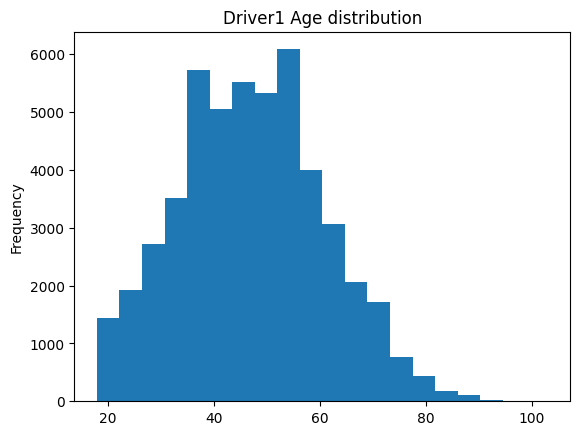

In [485]:
#Histogram of the frequency of the ages
quotes["Driver1_Age"].plot.hist(bins=20)
plt.title("Driver1 Age distribution")
plt.show()

The values are believable and the distribution makes sense, so no further action seems to be required. We move on to the next column, `Driver1_Licence_Type`. This is a categorical variable so we are going to explore its values.

In [486]:
# Possible values of the Driver 1 licence type
quotes["Driver1_Licence_Type"].unique()

array(['Full UK', 'Automatic', 'Provisional UK', 'Full EU/EEC'],
      dtype=object)

There are no missing values and all the possible values make sense so we continue with `Driver1_Licence_Years`. Let us look for missing values.

In [487]:
any(quotes["Driver1_Licence_Years"].isna()), 

(False,)

There are no missing values, let us have a look at the distribution.

In [488]:
# Minimum and maximum
quotes["Driver1_Licence_Years"].min(), quotes["Driver1_Licence_Years"].max()

(0.0, 64.0)

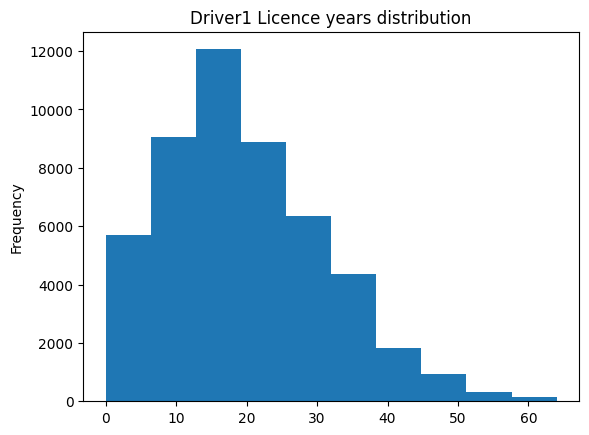

In [489]:
# Histogram of frequencies
quotes["Driver1_Licence_Years"].plot.hist()
plt.title("Driver1 Licence years distribution")
plt.show()

Everything looks good. However, it is likely that this variable is highly correlated with age. Let us check that.

In [490]:
# Correlation coefficient between age and licence years
quotes["Driver1_Age"].corr(quotes["Driver1_Licence_Years"])

0.688814004390955

We can see that the correlation is indeed relatively high. In order to have less correlated variables we are going to replace age by a new variable `Driver1_Age_Start_Licence` that represents the age at which the driver got its licence.

In [491]:
quotes["Driver1_Age"] -= quotes["Driver1_Licence_Years"]
quotes.rename(columns={"Driver1_Age":"Driver1_Age_Start_Licence"}, inplace=True)
quotes.head()

,Driver1_Age_Start_Licence,Driver1_Licence_Type,Driver1_Licence_Years,Driver2_Licence_Type,Driver2_Licence_Years,Driver1_Convictions,Driver1_Claims,Driver1_Marital_Status,Vehicle_Age,Vehicle_Value,Tax,Vehicle_Annual_Mileage,Credit_Score,Payment_Type,Days_to_Inception,Premium,Capped_Premium
0,27.0,Full UK,34.0,NaN,NaN,No,0,Married,4,24178,3626.70,12849.0,240,Monthly,11,707.64,707.64
1,30.0,Full UK,12.0,NaN,NaN,No,2,Married,14,1744,174.40,1250.0,200,Annual,4,1176.96,1176.96
2,21.0,Full UK,9.0,NaN,20.0,No,0,Married,5,20199,3029.85,21847.0,644,Annual,0,594.84,594.84
3,23.0,Full UK,17.0,Full UK,NaN,No,2,Married,6,12569,1885.35,12266.0,548,Annual,0,1282.56,1282.56
4,17.0,Full UK,25.0,Full UK,NaN,No,0,Separated,8,11395,1709.25,11117.0,393,Annual,30,1471.02,1471.02


We can see that now the correlation is significantly lower now.

In [492]:
# New correlation coefficient
quotes["Driver1_Age_Start_Licence"].corr(quotes["Driver1_Licence_Years"])

-0.19647248783827712

Next we get some information about Driver 2. We are leaving this for later since this part will have a particular relevance in our model. So for now, let us have a look at `Driver1_Convictions`. Let us check its values.

In [493]:
quotes["Driver1_Convictions"].unique()

array(['No', 'Yes', '-9999'], dtype=object)

We get a strange value of `-9999`. Let us compute how many entries have this value.

In [494]:
quotes[quotes["Driver1_Convictions"]=='-9999']["Driver1_Convictions"].count()

1140

The amount is about a 2% of the total number of rows. Dropping it would not be too detrimental. However, since we believe in "innocent until proven guilty", we are going to assume that this value should be replaced by "No" in order to keep most of the data. We also transform the the variable into a boolean one by using a dummy variable.

In [495]:
# Replace -9999 by No
quotes["Driver1_Convictions"].replace('-9999','No', inplace=True)

# Turn Yes to 1 and No to 0
quotes["Driver1_Convictions"]=pd.get_dummies(quotes["Driver1_Convictions"], drop_first=True)

quotes.head()

,Driver1_Age_Start_Licence,Driver1_Licence_Type,Driver1_Licence_Years,Driver2_Licence_Type,Driver2_Licence_Years,Driver1_Convictions,Driver1_Claims,Driver1_Marital_Status,Vehicle_Age,Vehicle_Value,Tax,Vehicle_Annual_Mileage,Credit_Score,Payment_Type,Days_to_Inception,Premium,Capped_Premium
0,27.0,Full UK,34.0,NaN,NaN,False,0,Married,4,24178,3626.70,12849.0,240,Monthly,11,707.64,707.64
1,30.0,Full UK,12.0,NaN,NaN,False,2,Married,14,1744,174.40,1250.0,200,Annual,4,1176.96,1176.96
2,21.0,Full UK,9.0,NaN,20.0,False,0,Married,5,20199,3029.85,21847.0,644,Annual,0,594.84,594.84
3,23.0,Full UK,17.0,Full UK,NaN,False,2,Married,6,12569,1885.35,12266.0,548,Annual,0,1282.56,1282.56
4,17.0,Full UK,25.0,Full UK,NaN,False,0,Separated,8,11395,1709.25,11117.0,393,Annual,30,1471.02,1471.02


The next variable is `Driver1_Claims`. Let us simply have a look at the distribution and missing values.

In [496]:
# No missing values, reasonable range
any(quotes["Driver1_Claims"].isna()), quotes["Driver1_Claims"].min(), quotes["Driver1_Claims"].max()

(False, 0, 6)

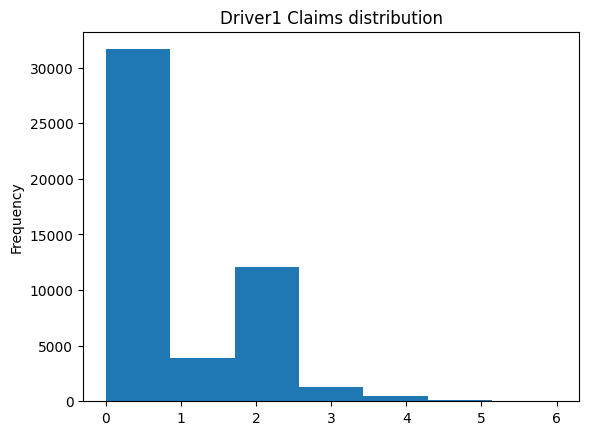

In [497]:
quotes["Driver1_Claims"].plot.hist(bins=7)
plt.title("Driver1 Claims distribution")
plt.show()

Everything looks alright. The next variable is `Driver1_Marital_Status`. It is tempting to drop this one since it does not seem to be so related to the driver abilities or to the vehicle. However, let us keep an open mind and let us see later what the importance of this variable is in the model. Therefore, let us explore its possible values.

In [498]:
quotes["Driver1_Marital_Status"].unique()

array(['Married', 'Separated', 'Widowed', 'Single', 'Other', 'Divorced',
       'Common Law', 'Civil Partnership', 'single', 'married'],
      dtype=object)

We see that there are some repeated values with different format, so we are just going to reformat them to Title style.

In [499]:
quotes["Driver1_Marital_Status"] = quotes["Driver1_Marital_Status"].apply(lambda x: x.title())
quotes["Driver1_Marital_Status"].unique()

array(['Married', 'Separated', 'Widowed', 'Single', 'Other', 'Divorced',
       'Common Law', 'Civil Partnership'], dtype=object)

Now we get a few columns about the vehicle. Let us explore them one by one. First, `Vehicle_Age`. As before, let us look for missing or incorrect values.

In [500]:
any(quotes["Vehicle_Age"].isna()), quotes["Vehicle_Age"].min(), quotes["Vehicle_Age"].max()

(False, -9999, 75)

We see that there is an incorrect value of -9999. Since there could potentially be other negative values, let us count how many there are.

In [501]:
quotes[quotes["Vehicle_Age"] < 0 ]["Vehicle_Age"].count()

85

Since there is a very small amount so we can either drop them or impute them. Since there is actually no reasonable criteria for imputation other than just filling with the average, our decision is to just drop them.

In [502]:
quotes = quotes[quotes["Vehicle_Age"] >= 0 ]

Now let us plot the distribution of the vehicle ages.

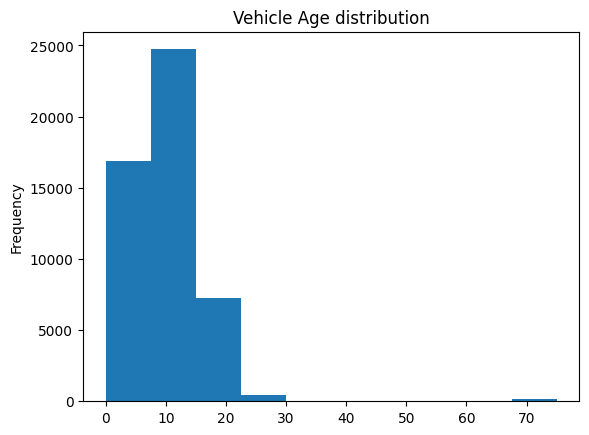

In [503]:
quotes["Vehicle_Age"].plot.hist()
plt.title("Vehicle Age distribution")
plt.show()

There seems to be a gap. This is confirmed by looking at the unique values.

In [504]:
# Last two values of age
sorted(quotes["Vehicle_Age"].unique())[-2:]

[36, 75]

We can see a jump between 36 and 75. This suggests that 75 might be a wrong age value. The histogram shows that there are very few vehicles with this age, so just in case we are dropping them.

In [505]:
quotes = quotes[quotes["Vehicle_Age"] < 75 ]

We do a similar analysis for `Vehicle_Value`.

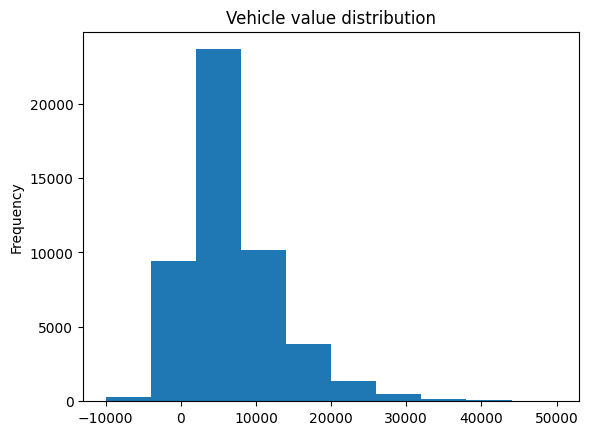

In [506]:
quotes["Vehicle_Value"].plot.hist()
plt.title("Vehicle value distribution")
plt.show()

The histogram shows negative values again and we drop them.

In [507]:
quotes = quotes[quotes["Vehicle_Value"] >= 0 ]

Next there is a tax column. Usually taxes are computed as a function of the vehicle value, among other variables, so we expect a high correlation between tax and age. 

In [508]:
quotes["Vehicle_Value"].corr(quotes["Tax"])

0.9688654451195808

The correlation is very high, so the Tax variable is redundant and we should drop it.

In [509]:
quotes.drop(columns=["Tax"], inplace=True)
quotes.head()

,Driver1_Age_Start_Licence,Driver1_Licence_Type,Driver1_Licence_Years,Driver2_Licence_Type,Driver2_Licence_Years,Driver1_Convictions,Driver1_Claims,Driver1_Marital_Status,Vehicle_Age,Vehicle_Value,Vehicle_Annual_Mileage,Credit_Score,Payment_Type,Days_to_Inception,Premium,Capped_Premium
0,27.0,Full UK,34.0,NaN,NaN,False,0,Married,4,24178,12849.0,240,Monthly,11,707.64,707.64
1,30.0,Full UK,12.0,NaN,NaN,False,2,Married,14,1744,1250.0,200,Annual,4,1176.96,1176.96
2,21.0,Full UK,9.0,NaN,20.0,False,0,Married,5,20199,21847.0,644,Annual,0,594.84,594.84
3,23.0,Full UK,17.0,Full UK,NaN,False,2,Married,6,12569,12266.0,548,Annual,0,1282.56,1282.56
4,17.0,Full UK,25.0,Full UK,NaN,False,0,Separated,8,11395,11117.0,393,Annual,30,1471.02,1471.02


Another variable that could be highly correlated with `Vehicle_Value` is the previously analysed `Vehicle_Age`. 

In [510]:
quotes["Vehicle_Value"].corr(quotes["Vehicle_Age"])

-0.7255358659528235

The correlation is indeed quite high. Since the value is more relevant in terms of how much the insurance would have to pay, we could drop the age. However, we will guide this decision later using the variance inflation factor.

The last variable related to the car is its annual mileage. Let us explore its distribution.

In [511]:
# No missing values, a negative value
any(quotes["Vehicle_Annual_Mileage"].isna()), quotes["Vehicle_Annual_Mileage"].min(), quotes["Vehicle_Annual_Mileage"].max()

(False, -9999.0, 200000.0)

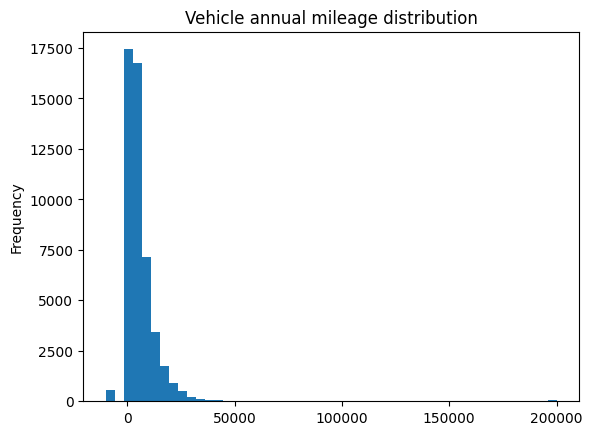

In [512]:
quotes["Vehicle_Annual_Mileage"].plot.hist(bins=50)
plt.title("Vehicle annual mileage distribution")
plt.show()

The histogram shows a small amount of negative values and a gap, so we drop these seemingly erroneous values.

In [513]:
quotes = quotes[(20000 > quotes["Vehicle_Annual_Mileage"]) & (quotes["Vehicle_Annual_Mileage"]>=0)]

The next variable is the credit score. We can see that there are no missing values and that they range between plausible values for the credit score (it should be within the range 0-999).

In [514]:
any(quotes["Credit_Score"].isna()),quotes["Credit_Score"].min(),quotes["Credit_Score"].max()

(False, 0, 799)

After this we get the payment type. Let us see the possible values.

In [515]:
quotes["Payment_Type"].unique()

array(['Monthly', 'Annual'], dtype=object)

There are only two possible payments. We expect the price of the monthly payment to be slightly higher than the annual payment due to the interest. We can confirm this by computing some statisticals and by doing a boxplot. For this we also use the `Premium` column, which should be the payment done.

In [516]:
# Average value of each payment type
quotes.groupby("Payment_Type")["Premium"].mean()

Payment_Type
Annual      995.004972
Monthly    1027.792107
Name: Premium, dtype: float64

We see that as expected, the annual premium is lower on average. This also suggests that `Premium` refers to the total amount paid and not the amount paid in each period. As we mention we also draw a boxplot to understand the distribution better.

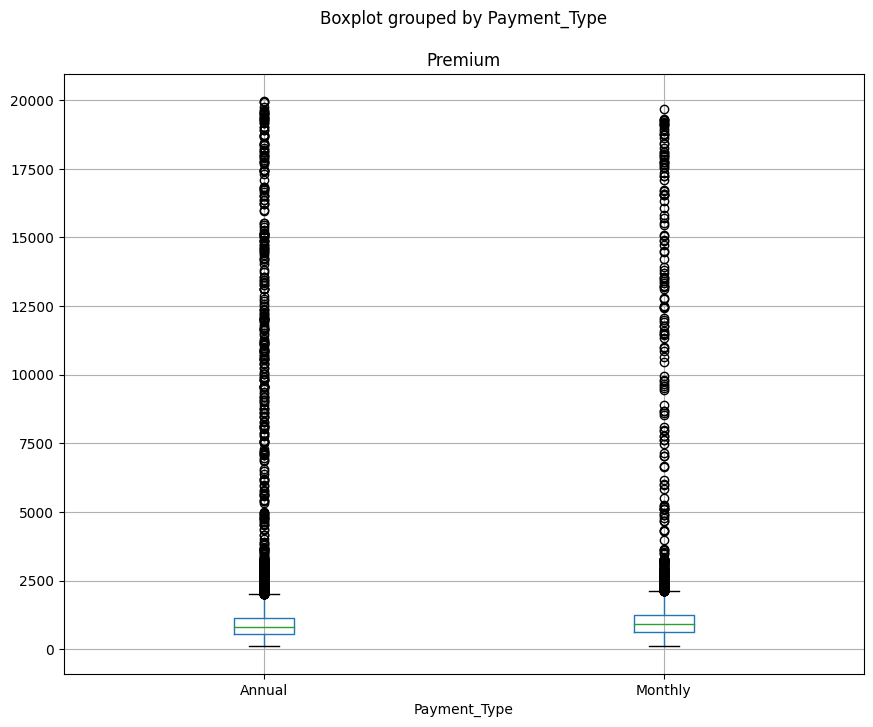

In [517]:
fig, ax = plt.subplots(figsize=(10,8))
quotes.boxplot(column="Premium", by="Payment_Type", ax=ax)
plt.show()

The boxplot shows that there are many "outliers". When there are so many, we should actually consider them to be part of a distribution with a fat tail, something very common in variables that measure prices or salaries. Therefore, we are just going to replace this variable by a dummy variable telling whether the payment type is monthly or not.

In [518]:
quotes["Payment_Type"]=pd.get_dummies(quotes["Payment_Type"], drop_first=True)
quotes.rename(columns={"Payment_Type":"Monthly"}, inplace=True)
quotes.head()

,Driver1_Age_Start_Licence,Driver1_Licence_Type,Driver1_Licence_Years,Driver2_Licence_Type,Driver2_Licence_Years,Driver1_Convictions,Driver1_Claims,Driver1_Marital_Status,Vehicle_Age,Vehicle_Value,Vehicle_Annual_Mileage,Credit_Score,Monthly,Days_to_Inception,Premium,Capped_Premium
0,27.0,Full UK,34.0,NaN,NaN,False,0,Married,4,24178,12849.0,240,True,11,707.64,707.64
1,30.0,Full UK,12.0,NaN,NaN,False,2,Married,14,1744,1250.0,200,False,4,1176.96,1176.96
3,23.0,Full UK,17.0,Full UK,NaN,False,2,Married,6,12569,12266.0,548,False,0,1282.56,1282.56
4,17.0,Full UK,25.0,Full UK,NaN,False,0,Separated,8,11395,11117.0,393,False,30,1471.02,1471.02
5,18.0,Full UK,45.0,Automatic,20.0,False,2,Married,5,6172,3589.0,689,True,0,730.98,730.98


We have skipped the `Days_To_Inception` column. This seems to be the number of days between hiring the insurance covering and it being effecive. We can have a look at the range.

In [519]:
quotes["Days_to_Inception"].min(),quotes["Days_to_Inception"].max()

(0, 30)

The number of days is always less than 30, suggesting that maybe the insurance covering becomes effective on a fixed day of each month. This variable is therefore not relevant for the model and we drop it.

In [520]:
quotes.drop(columns=["Days_to_Inception"],inplace=True)
quotes.head()

,Driver1_Age_Start_Licence,Driver1_Licence_Type,Driver1_Licence_Years,Driver2_Licence_Type,Driver2_Licence_Years,Driver1_Convictions,Driver1_Claims,Driver1_Marital_Status,Vehicle_Age,Vehicle_Value,Vehicle_Annual_Mileage,Credit_Score,Monthly,Premium,Capped_Premium
0,27.0,Full UK,34.0,NaN,NaN,False,0,Married,4,24178,12849.0,240,True,707.64,707.64
1,30.0,Full UK,12.0,NaN,NaN,False,2,Married,14,1744,1250.0,200,False,1176.96,1176.96
3,23.0,Full UK,17.0,Full UK,NaN,False,2,Married,6,12569,12266.0,548,False,1282.56,1282.56
4,17.0,Full UK,25.0,Full UK,NaN,False,0,Separated,8,11395,11117.0,393,False,1471.02,1471.02
5,18.0,Full UK,45.0,Automatic,20.0,False,2,Married,5,6172,3589.0,689,True,730.98,730.98


Finally, there is a `Capped_Premium` column. This is supposed to be a limit to the Premium, usually for renewal. At first glance, it seems to be equal to the premium in some cases, so let us explore when it is not.

In [521]:
# Values of Capped Premium when it is not equal to Premium
quotes[quotes["Premium"] != quotes["Capped_Premium"]]["Capped_Premium"].unique()

array([4000.])

We see that there is a unique value of capped premium that is applied. We are not taking this value into account since it is fixed for every customer.

In [522]:
quotes.drop(columns=["Capped_Premium"], inplace=True)
quotes.head()

,Driver1_Age_Start_Licence,Driver1_Licence_Type,Driver1_Licence_Years,Driver2_Licence_Type,Driver2_Licence_Years,Driver1_Convictions,Driver1_Claims,Driver1_Marital_Status,Vehicle_Age,Vehicle_Value,Vehicle_Annual_Mileage,Credit_Score,Monthly,Premium
0,27.0,Full UK,34.0,NaN,NaN,False,0,Married,4,24178,12849.0,240,True,707.64
1,30.0,Full UK,12.0,NaN,NaN,False,2,Married,14,1744,1250.0,200,False,1176.96
3,23.0,Full UK,17.0,Full UK,NaN,False,2,Married,6,12569,12266.0,548,False,1282.56
4,17.0,Full UK,25.0,Full UK,NaN,False,0,Separated,8,11395,11117.0,393,False,1471.02
5,18.0,Full UK,45.0,Automatic,20.0,False,2,Married,5,6172,3589.0,689,True,730.98


## Variance Inflaction Coefficient

We know use the VIF coefficient to eliminate any potentially redundant columns. We apply this only to numerical variables other than Premium (since premium should be explained by the rest).

In [526]:

X = add_constant(quotes[["Driver1_Age_Start_Licence", "Driver1_Licence_Years", "Driver1_Claims", "Vehicle_Value", "Vehicle_Age", "Vehicle_Annual_Mileage", "Credit_Score"]])
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns) 

const                        38.080673
Driver1_Age_Start_Licence     1.044837
Driver1_Licence_Years         1.058902
Driver1_Claims                1.001612
Vehicle_Value                 3.263060
Vehicle_Age                   2.160980
Vehicle_Annual_Mileage        2.312428
Credit_Score                  1.000105
dtype: float64

We observe that `Vehicle_Value` has the highest VIF, so it may actually be better to drop this variable than `Vehicle_Age`, unlike we previously thought.

In [527]:
# drop the column and recompute VIF
quotes.drop(columns=["Vehicle_Value"], inplace=True)
X = add_constant(quotes[["Driver1_Age_Start_Licence", "Driver1_Licence_Years", "Driver1_Claims", "Vehicle_Age", "Vehicle_Annual_Mileage", "Credit_Score"]])
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns) 

const                        29.723802
Driver1_Age_Start_Licence     1.041857
Driver1_Licence_Years         1.053667
Driver1_Claims                1.001514
Vehicle_Age                   1.526343
Vehicle_Annual_Mileage        1.516827
Credit_Score                  1.000079
dtype: float64

Now every VIF coefficient is around 1, so we can keep the remaining variables.

## Drivers

We are going back to the drivers now. We can see that we have less information about Driver 2 than about Driver 1. It may be useful to have the same amount of information. Let us see how many missing values for the licence years.

In [528]:
# Total number of missing values
quotes["Driver2_Licence_Years"].isna().sum()

22836

The amount of missing values is very high compare to the total amount of entries. Therefore, we should fill it. Since the only extra iformation about Driver 2 that we have is the licence type, we are going to fill with the average of the corresponding licence type. We saw that there are missing values on the Driver 2 licence type in the first few rows already. We are going to treat `NaN` as another group. 

However, we make an exception. We are going to assume that the combination `NaN` Driver 2 licence years and `NaN` Driver 2 licence type means that there is no driver 2. This will lead to two different datasets and therefore two different models. 

Alternatively, we could create a new variable that tells whether there is a second driver or not. We do not do this because it requires more data processing, and we may lose precision.

## Single Drivers
 We start exploring the data for single drivers.


In [529]:
single_drivers = quotes[(quotes["Driver2_Licence_Type"].isna()) & (quotes["Driver2_Licence_Years"].isna())].drop(columns=["Driver2_Licence_Type", "Driver2_Licence_Years"], inplace=False)
single_drivers

,Driver1_Age_Start_Licence,Driver1_Licence_Type,Driver1_Licence_Years,Driver1_Convictions,Driver1_Claims,Driver1_Marital_Status,Vehicle_Age,Vehicle_Annual_Mileage,Credit_Score,Monthly,Premium
0,27.0,Full UK,34.0,False,0,Married,4,12849.0,240,True,707.64
1,30.0,Full UK,12.0,False,2,Married,14,1250.0,200,False,1176.96
14,17.0,Full UK,25.0,False,2,Divorced,10,1193.0,669,True,334.98
16,17.0,Full UK,32.0,False,0,Separated,13,4930.0,396,False,1839.00
23,30.0,Full UK,18.0,False,0,Divorced,7,4385.0,791,False,264.21
...,...,...,...,...,...,...,...,...,...,...,...
49607,20.0,Full UK,34.0,False,0,Divorced,5,4103.0,732,False,528.03
49608,27.0,Full UK,0.0,False,3,Married,7,6770.0,225,True,2135.49
49618,32.0,Full UK,23.0,False,2,Single,20,1102.0,784,False,923.13
49625,17.0,Automatic,10.0,True,3,Single,6,9100.0,710,True,1521.78


We need to encode the categorical values so that we can use them in our model.

In [531]:
le = preprocessing.LabelEncoder()
single_drivers["Driver1_Licence_Type"]=le.fit_transform(single_drivers["Driver1_Licence_Type"])
single_drivers["Driver1_Marital_Status"]=le.fit_transform(single_drivers["Driver1_Marital_Status"])
single_drivers

,Driver1_Age_Start_Licence,Driver1_Licence_Type,Driver1_Licence_Years,Driver1_Convictions,Driver1_Claims,Driver1_Marital_Status,Vehicle_Age,Vehicle_Annual_Mileage,Credit_Score,Monthly,Premium
0,27.0,1,34.0,False,0,3,4,12849.0,240,True,707.64
1,30.0,1,12.0,False,2,3,14,1250.0,200,False,1176.96
14,17.0,1,25.0,False,2,2,10,1193.0,669,True,334.98
16,17.0,1,32.0,False,0,5,13,4930.0,396,False,1839.00
23,30.0,1,18.0,False,0,2,7,4385.0,791,False,264.21
...,...,...,...,...,...,...,...,...,...,...,...
49607,20.0,1,34.0,False,0,2,5,4103.0,732,False,528.03
49608,27.0,1,0.0,False,3,3,7,6770.0,225,True,2135.49
49618,32.0,1,23.0,False,2,6,20,1102.0,784,False,923.13
49625,17.0,0,10.0,True,3,6,6,9100.0,710,True,1521.78


We can see that the amount of single drivers is almost 8000, so it is big enough to create a good model. Next we split our dataset into train and test features and targets. We are going to use a tree based model, which usually has problems with extrapolation, so we also make sure that the highest train target is not too much higher than the highest test target.

In [533]:

X,y = single_drivers.iloc[:,:-1], single_drivers.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train.max(), y_test.max()

(19692.41, 19968.44)

We choose XGBooster regressor, as it is a very powerful regression model. It is tree based, which work well with a mixture of categorical and numerical data. This model is also more optimized than other Random Forest models thanks to the gradiant boosting, and it allows to tune the learning rate.

DO SOME PARAMETER TUNING

In [534]:

single_drivers_model = XGBRegressor(eta=0.99, max_depth = 10)


In [535]:
single_drivers_model.fit(X,y)  

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.99, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [536]:
single_drivers_model.score(X_train,y_train),single_drivers_model.score(X_test,y_test)

(0.9999993965403335, 0.9999995411020745)

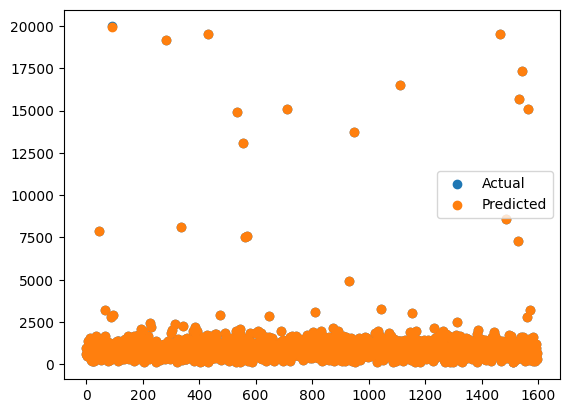

In [537]:

y_predict = single_drivers_model.predict(X_test)
plt.scatter(np.arange(len(y_predict)), y_test, label = "Actual")
plt.scatter(np.arange(len(y_predict)), y_predict, label = "Predicted")
plt.legend()
plt.show()

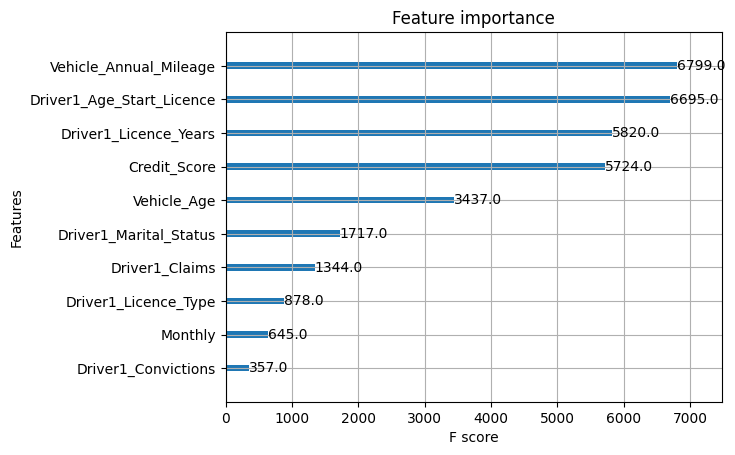

In [538]:

plot_importance(single_drivers_model)
plt.show()

In [15]:

mean_squared_error(y_predict, y_test), np.std(y_test) #https://stats.stackexchange.com/questions/579755/whats-a-reasonable-mean-squared-error-or-rmse

(1.8157041685820368, 1370.138892378198)

# 2 drivers

In [66]:
two_drivers =quotes[~((quotes["Driver2_Licence_Type"].isna()) & (quotes["Driver2_Licence_Years"].isna()))]
two_drivers

,Driver1_Age_Start_Licence,Driver1_Licence_Type,Driver1_Licence_Years,Driver2_Licence_Type,Driver2_Licence_Years,Driver1_Convictions,Driver1_Claims,Driver1_Marital_Status,Vehicle_Age,Vehicle_Value,Vehicle_Annual_Mileage,Credit_Score,Monthly,Premium
3,23.0,Full UK,17.0,Full UK,NaN,False,2,Married,6,12569,12266.0,548,False,1282.56
4,17.0,Full UK,25.0,Full UK,NaN,False,0,Separated,8,11395,11117.0,393,False,1471.02
5,18.0,Full UK,45.0,Automatic,20.0,False,2,Married,5,6172,3589.0,689,True,730.98
6,20.0,Full UK,1.0,Provisional UK,22.0,False,0,Widowed,9,2303,2239.0,706,True,1443.33
7,35.0,Full UK,27.0,Automatic,13.0,False,0,Single,10,6574,3581.0,785,True,642.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49636,17.0,Full UK,12.0,NaN,24.0,False,0,Other,14,1633,1074.0,397,False,451.50
49637,26.0,Full UK,1.0,Full UK,25.0,False,0,Married,6,8050,2987.0,158,True,1375.59
49638,17.0,Automatic,13.0,NaN,24.0,False,0,Civil Partnership,8,11124,3364.0,328,False,1207.05
49639,71.0,Full UK,0.0,Provisional UK,11.0,False,0,Single,3,10821,9303.0,277,True,1776.93


In [67]:
two_drivers["Vehicle_Age"].corr(two_drivers["Vehicle_Value"])

-0.7265833667208137

In [68]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(two_drivers[["Driver1_Age_Start_Licence", "Driver1_Licence_Years", "Driver1_Claims", "Vehicle_Age", "Vehicle_Annual_Mileage", "Credit_Score"]])
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns) 
# when I drop Vehicle value every vif's around 1
two_drivers.drop(columns = ["Vehicle_Value"], inplace = True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_4032\3025827105.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_drivers.drop(columns = ["Vehicle_Value"], inplace = True)


In [69]:
two_drivers.groupby("Driver2_Licence_Type")["Driver2_Licence_Years"].mean() #fill each group with its mean
# Full Non EU/EEC has only NaN values, so fill with overall mean (and there are only two of them)

Driver2_Licence_Type
Automatic             20.759259
Full EU/EEC           18.777778
Full International    19.163265
Full Non EU/EEC             NaN
Full UK               22.366933
Provisional UK        20.581522
Name: Driver2_Licence_Years, dtype: float64

In [70]:
two_drivers[two_drivers["Driver2_Licence_Type"] == "Full Non EU/EEC"]

,Driver1_Age_Start_Licence,Driver1_Licence_Type,Driver1_Licence_Years,Driver2_Licence_Type,Driver2_Licence_Years,Driver1_Convictions,Driver1_Claims,Driver1_Marital_Status,Vehicle_Age,Vehicle_Annual_Mileage,Credit_Score,Monthly,Premium
726,32.0,Provisional UK,39.0,Full Non EU/EEC,NaN,True,0,Civil Partnership,10,1435.0,767,True,489.24
14863,18.0,Provisional UK,17.0,Full Non EU/EEC,NaN,True,1,Married,16,1026.0,239,True,978.03


In [71]:
two_drivers["Driver2_Licence_Years"] = two_drivers.groupby("Driver2_Licence_Type", dropna=False)["Driver2_Licence_Years"].transform(lambda x: x.fillna(x.mean())) #by default groupby drops NaN and I don't want to lose nan driver licence with years


C:\Users\Usuario\AppData\Local\Temp\ipykernel_4032\2259414229.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_drivers["Driver2_Licence_Years"] = two_drivers.groupby("Driver2_Licence_Type", dropna=False)["Driver2_Licence_Years"].transform(lambda x: x.fillna(x.mean())) #by default groupby drops NaN and I don't want to lose nan driver licence with years


In [72]:
two_drivers["Driver2_Licence_Years"].fillna(two_drivers["Driver2_Licence_Years"].mean(), inplace=True)
two_drivers

C:\Users\Usuario\AppData\Local\Temp\ipykernel_4032\854736404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_drivers["Driver2_Licence_Years"].fillna(two_drivers["Driver2_Licence_Years"].mean(), inplace=True)


,Driver1_Age_Start_Licence,Driver1_Licence_Type,Driver1_Licence_Years,Driver2_Licence_Type,Driver2_Licence_Years,Driver1_Convictions,Driver1_Claims,Driver1_Marital_Status,Vehicle_Age,Vehicle_Annual_Mileage,Credit_Score,Monthly,Premium
3,23.0,Full UK,17.0,Full UK,22.366933,False,2,Married,6,12266.0,548,False,1282.56
4,17.0,Full UK,25.0,Full UK,22.366933,False,0,Separated,8,11117.0,393,False,1471.02
5,18.0,Full UK,45.0,Automatic,20.000000,False,2,Married,5,3589.0,689,True,730.98
6,20.0,Full UK,1.0,Provisional UK,22.000000,False,0,Widowed,9,2239.0,706,True,1443.33
7,35.0,Full UK,27.0,Automatic,13.000000,False,0,Single,10,3581.0,785,True,642.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49636,17.0,Full UK,12.0,NaN,24.000000,False,0,Other,14,1074.0,397,False,451.50
49637,26.0,Full UK,1.0,Full UK,25.000000,False,0,Married,6,2987.0,158,True,1375.59
49638,17.0,Automatic,13.0,NaN,24.000000,False,0,Civil Partnership,8,3364.0,328,False,1207.05
49639,71.0,Full UK,0.0,Provisional UK,11.000000,False,0,Single,3,9303.0,277,True,1776.93


In [73]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
two_drivers["Driver1_Licence_Type"]=le.fit_transform(two_drivers["Driver1_Licence_Type"])
two_drivers["Driver2_Licence_Type"]=le.fit_transform(two_drivers["Driver2_Licence_Type"])
two_drivers["Driver1_Marital_Status"]=le.fit_transform(two_drivers["Driver1_Marital_Status"])
two_drivers

C:\Users\Usuario\AppData\Local\Temp\ipykernel_4032\2975542393.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_drivers["Driver1_Licence_Type"]=le.fit_transform(two_drivers["Driver1_Licence_Type"])
C:\Users\Usuario\AppData\Local\Temp\ipykernel_4032\2975542393.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_drivers["Driver2_Licence_Type"]=le.fit_transform(two_drivers["Driver2_Licence_Type"])
C:\Users\Usuario\AppData\Local\Temp\ipykernel_4032\2975542393.py:5: SettingWithCopyWarning: 
A value is 

,Driver1_Age_Start_Licence,Driver1_Licence_Type,Driver1_Licence_Years,Driver2_Licence_Type,Driver2_Licence_Years,Driver1_Convictions,Driver1_Claims,Driver1_Marital_Status,Vehicle_Age,Vehicle_Annual_Mileage,Credit_Score,Monthly,Premium
3,23.0,2,17.0,4,22.366933,False,2,3,6,12266.0,548,False,1282.56
4,17.0,2,25.0,4,22.366933,False,0,5,8,11117.0,393,False,1471.02
5,18.0,2,45.0,0,20.000000,False,2,3,5,3589.0,689,True,730.98
6,20.0,2,1.0,5,22.000000,False,0,7,9,2239.0,706,True,1443.33
7,35.0,2,27.0,0,13.000000,False,0,6,10,3581.0,785,True,642.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49636,17.0,2,12.0,6,24.000000,False,0,4,14,1074.0,397,False,451.50
49637,26.0,2,1.0,4,25.000000,False,0,3,6,2987.0,158,True,1375.59
49638,17.0,0,13.0,6,24.000000,False,0,0,8,3364.0,328,False,1207.05
49639,71.0,2,0.0,5,11.000000,False,0,6,3,9303.0,277,True,1776.93


In [74]:
X,y = two_drivers.iloc[:,:-1], two_drivers.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train.max(), y_test.max()

(19946.7, 19275.39)

In [75]:
model = XGBRegressor(eta=0.99, max_depth = 15)
model.fit(X,y)  
model.score(X_train,y_train),model.score(X_test,y_test)

(0.9999999994446165, 0.9999999993933394)

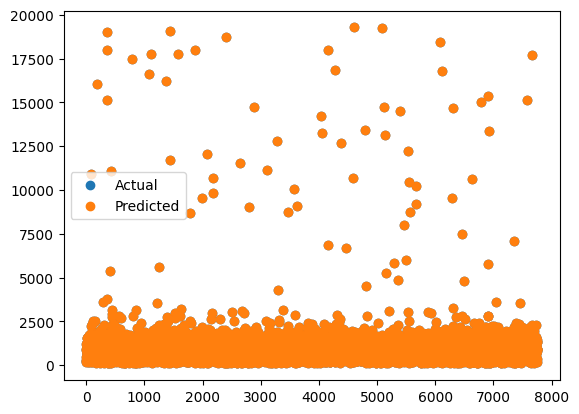

In [76]:
import matplotlib.pyplot as plt
y_predict = model.predict(X_test)
plt.scatter(np.arange(len(y_predict)), y_test, label = "Actual")
plt.scatter(np.arange(len(y_predict)), y_predict, label = "Predicted")
plt.legend()
plt.show()

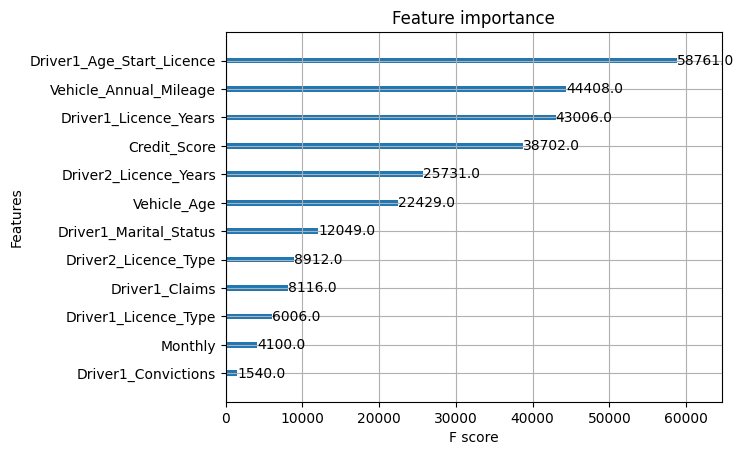

In [78]:
from xgboost import plot_importance
plot_importance(model)
plt.show()

In [ ]:
mean_squared_error(y_predict, y_test), np.std(y_test)

(0.0012421111030296314, 1182.984774022659)